<a href="https://colab.research.google.com/github/Hristo2076/ml_processes/blob/main/Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Цель:** закрепить знания о математическом смысле метрик TPR, FPR. Изучить построение ROC-кривой, графика Precision-Recall.


##**Описание задания:**
Решить задачу классификации при помощи обучения модели логистической регрессии. Качество модели оценивается путем подсчета метрик TPR, FPR и построения графиков ROC-кривой, Precision-Recall. Данные для обучения модели хранятся в файле athletes.csv, который можно найти в материалах к занятию.

In [559]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [560]:
#imports 

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders.backward_difference import BackwardDifferenceEncoder
from sklearn.linear_model import LogisticRegression
#metrics
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

#validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold


In [561]:
df = pd.read_csv('athletes.csv').drop('id',axis=1)

In [562]:
df[:5]

,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


###**1. Преобразуйте данные:**
1. проверьте наличие пропущенных значений. Преобразуйте/удалите пропуски по необходимости; 
2. закодируйте категориальные переменные числовыми значениями по необходимости.

In [563]:
df.describe()

,height,weight,gold,silver,bronze
count,11208.000000,10879.000000,11538.000000,11538.000000,11538.000000
mean,1.766282,72.068205,0.057722,0.056769,0.061016
std,0.112719,16.177334,0.255910,0.239147,0.243320
min,1.210000,31.000000,0.000000,0.000000,0.000000
25%,1.690000,60.000000,0.000000,0.000000,0.000000
50%,1.760000,70.000000,0.000000,0.000000,0.000000
75%,1.840000,81.000000,0.000000,0.000000,0.000000
max,2.210000,170.000000,5.000000,2.000000,2.000000


In [564]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         11538 non-null  object 
 1   nationality  11538 non-null  object 
 2   sex          11538 non-null  object 
 3   dob          11537 non-null  object 
 4   height       11208 non-null  float64
 5   weight       10879 non-null  float64
 6   sport        11538 non-null  object 
 7   gold         11538 non-null  int64  
 8   silver       11538 non-null  int64  
 9   bronze       11538 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 901.5+ KB


In [565]:
df.isna().sum()

name             0
nationality      0
sex              0
dob              1
height         330
weight         659
sport            0
gold             0
silver           0
bronze           0
dtype: int64

In [566]:
now = pd.Timestamp('now')

df.dob = pd.to_datetime(df.dob)
df['age'] = np.sqrt((now - df['dob']).astype('<m8[Y]')**2) 

In [567]:
df.age

0        47.0
1        36.0
2        30.0
3        32.0
4        32.0
         ... 
11533    27.0
11534    36.0
11535    31.0
11536    34.0
11537    31.0
Name: age, Length: 11538, dtype: float64

In [568]:
#заполняем пропуски роста средним значением роста ,группируя сначало по возрасту потом по виду спорта
#Заполняем пропуски веса средним значением веса, группируя сначало по возросту потом по росту

df.height.fillna(df.groupby(['age','sport'])['height'].transform('mean'),inplace=True)
df.weight.fillna(df.groupby(['age','height'])['weight'].transform('mean'),inplace=True)

In [569]:
#Удаляем те строки доступ которым мы не получили
df = df[ pd.isnull( df['weight'] ) == 0 ]

In [570]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11350 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   name         11350 non-null  object        
 1   nationality  11350 non-null  object        
 2   sex          11350 non-null  object        
 3   dob          11350 non-null  datetime64[ns]
 4   height       11350 non-null  float64       
 5   weight       11350 non-null  float64       
 6   sport        11350 non-null  object        
 7   gold         11350 non-null  int64         
 8   silver       11350 non-null  int64         
 9   bronze       11350 non-null  int64         
 10  age          11350 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 1.0+ MB


In [571]:
df.isna().sum()

name           0
nationality    0
sex            0
dob            0
height         0
weight         0
sport          0
gold           0
silver         0
bronze         0
age            0
dtype: int64

In [572]:
df[:50:5]

,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze,age
0,A Jesus Garcia,ESP,male,2069-10-17,1.72,64.0,athletics,0,0,0,47.0
5,Aaron Royle,AUS,male,1990-01-26,1.80,67.0,triathlon,0,0,0,33.0
10,Abadi Hadis,ETH,male,1997-11-06,1.70,63.0,athletics,0,0,0,25.0
16,Abbos Rakhmonov,UZB,male,1998-07-07,1.61,57.0,wrestling,0,0,0,24.0
21,Abdalelah Haroun,QAT,male,1997-01-01,1.85,80.0,athletics,0,0,0,26.0
26,Abdelaziz Mohamed Ahmed,SUD,male,1994-10-12,1.81,72.0,aquatics,0,0,0,28.0
31,Abdelkadir Salhi,ALG,male,1993-03-19,1.85,79.0,football,0,0,0,30.0
36,Abdelmalik Lahoulou,ALG,male,1992-05-07,1.77,72.0,athletics,0,0,0,31.0
41,Abderrahmane Meziane,ALG,male,1994-03-07,1.68,62.0,football,0,0,0,29.0
46,Abdoulkarim Fawziya,CMR,female,1989-03-01,1.80,67.0,volleyball,0,0,0,34.0


In [573]:
#Можно удалить следующие колонки ['dob','name']
#'dob' Я перевел в возраст
#'name' никак не будет влиять на работу модели

df = df.drop(['name','dob'],axis=1)

In [574]:
print(f'sport: {len(df.sport.unique())}\nnationality: {len(df.nationality.unique())}')


sport: 28
nationality: 207


In [575]:
#Большое количество уникальных значений в столбуах ['sport','nationality'], лучше использовать метод LabelEncoder
df.sex = LabelEncoder().fit_transform(df.sex)
df.nationality = LabelEncoder().fit_transform(df.nationality)


In [576]:
bd = BackwardDifferenceEncoder().fit_transform(sorted(df.sport),verbose=1)

df = pd.concat([df,bd],axis=1)

In [577]:
df = df.drop('sport',axis=1)

In [578]:
df = df[ pd.isnull( df['0_0']) == 0 ]
df = df[ pd.isnull( df.age) == 0 ]

In [579]:
df.isna().sum().sum()

0

###2. Разделите выборку на обучающее (80% данных) и тестовое (20% данных) подмножества.


In [580]:
df.gold = df.gold.apply(lambda x: 0 if x ==0 else 1)


In [581]:
X = df.drop('gold',axis=1)
y = df.gold

In [582]:
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 test_size = 0.2,
                                                 random_state=42)

###3. Постройте ROC-кривую с помощью функции sklearn.metrics. roc_curve.

In [583]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('LR',LogisticRegression(max_iter=1000))])

pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('LR', LogisticRegression(max_iter=1000))])

In [584]:
predictions = pipe.predict_proba(X_test)

In [585]:
pipe.score(X_test,y_test)

0.9471562919838782

In [586]:
pred = pipe.predict(X_test)


In [587]:
fpr,tpr,tres = roc_curve(y_test,predictions[:,1])

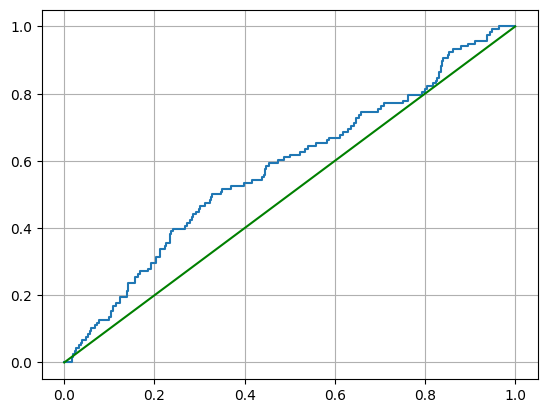

In [588]:
plt.plot(fpr,tpr)
a = [0,1]
b = [0,1]
plt.plot(a,b,color='g')
plt.grid()
plt.show()

###4. Вычислите значение ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score.

In [589]:
roc_auc_score( y_test, predictions[:, 1] )

0.5774852746724366

###5. Реализуйте подсчет метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn.
###6. Постройте ROC-кривую с помощью вычисленных в п. 5 метрик: объедините графики из п. 3 и п. 6 в один. Сравните, сделайте вывод.

In [592]:
thresholds = np.arange(0, 1, 0.1)
#predictions определены выше
fprs = []
tprs = []
prs = []
res = []
pr_custom = []
for threshold in thresholds:
    tp = 0 # True positive
    fp = 0 # False positive
    fn = 0 # False negative
    tn = 0 # True negative
    for predicted_prob, actual in zip( predictions[:, 1], y_test ):
        if predicted_prob >= threshold:
            predicted = 1
        else:
            predicted = 0

        if predicted == 1:
            if actual == 1:
                tp += 1
            else:
                fp += 1

        else:
            if actual == 1:
                fn += 1
            else:
                tn += 1
    try:
      tpr2 = tp/(tp + fn)
      fpr2 = fp/(fp + tn)
      precision = tp/(tp + fp)
      recall = tpr2 #по определению
      fprs.append(fpr2)
      tprs.append(tpr2)
      prs.append(precision)
      res.append(recall)
    except ZeroDivisionError:
      tpr2 = 0 

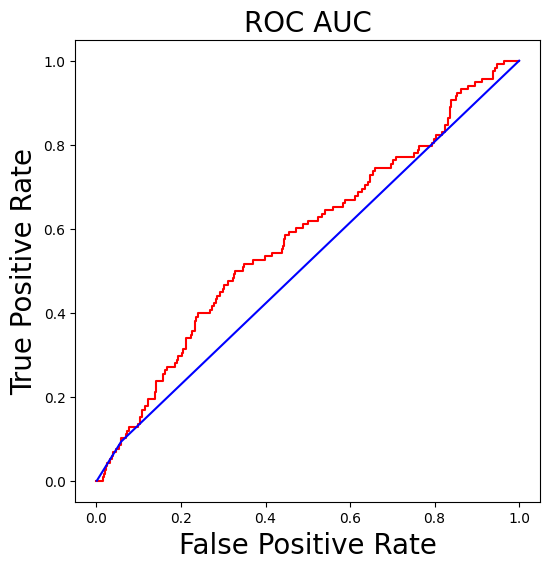

In [594]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="red")
plt.plot(fprs, tprs, color="blue")
plt.title('ROC AUC', fontdict={'fontsize': 20})
plt.xlabel('False Positive Rate', fontdict={'fontsize': 20})
plt.ylabel('True Positive Rate', fontdict={'fontsize': 20})
plt.show()

###7. Постройте график Precision-Recall, используя метрики, посчитанные в п. 5.

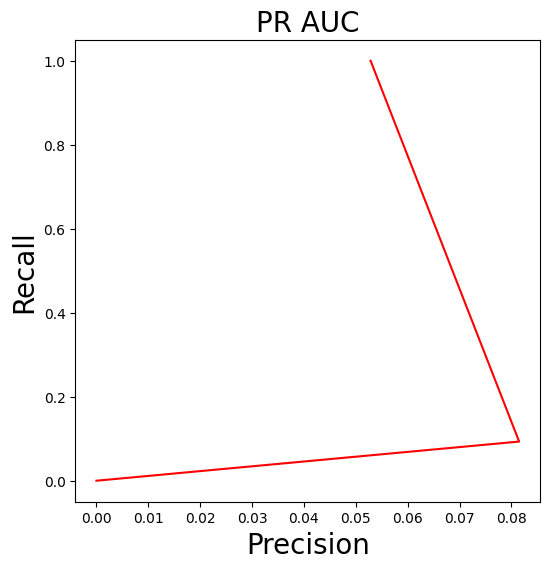

In [596]:
plt.figure(figsize=(6, 6))
plt.plot(prs, res, color="red")
plt.title('PR AUC', fontdict={'fontsize': 20})
plt.xlabel('Precision', fontdict={'fontsize': 20})
plt.ylabel('Recall', fontdict={'fontsize': 20})
plt.show()

###8. *Вычислите значение ROC-AUC метрики, используя метрики, посчитанные в п. 5.

In [597]:
#сортируем по возрастанию, чтобы считать от начала кривой
fprs.sort()
tprs.sort()
#кастомная метрика roc_auc - аналог roc_auc_score, очень приблизительно моделируем площадь фигуры как сумму фигур по шагам
custom_roc_auc = 0
prev_fpr = 0
prev_tpr = 0
for index in range(len(fprs)):
    if(index != 0):
        custom_roc_auc += ((tprs[index] - prev_tpr) * (fprs[index] - prev_fpr) / 2) + (tprs[index] * (fprs[index] - prev_fpr))
        prev_tpr = tprs[index]
        prev_fpr = fprs[index]
print(custom_roc_auc)

1.3763773690748087


### 9. Сформулируйте выводы по проделанной работе:
1. как по полученным графикам сделать вывод о качестве модели? Как вы оцениваете обученную модель исходя из подсчитанных метрик?
2. *может ли ROC-кривая проходить ниже диагонали?

Проделаная работа очень хорошо показывает минус метрики качества `accuracy`, по игрался с преобразованиями и получил хороший результат на тестовой выборке , что позже опровергли метрические показатели `ROC-AUC`. графики построенные при помощи расчетов библиотеки `sklearn` более точные и лучше описывают сушность метрики, нежели ручной расчет параметров.В целом моя модель достаточно рандомно предсказывает владельцов золотых медалей 